In [1]:
!pip install xgboost pandas -q

In [2]:
import os, random
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import warnings
import time
from joblib import Parallel, delayed
from lightgbm import LGBMClassifier
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

def set_seed(seed=3407):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(3407)

In [ ]:
data_dir_train = "./npy-files/results"   
data_dir_test  = "./npy-files/test"       

X_train_norm = np.load(f"{data_dir_train}/X_all.npy")
y_train      = np.load(f"{data_dir_train}/y_all.npy")
X_hmm_train  = np.load(f"{data_dir_train}/X_all_hmm.npy")

X_test_norm  = np.load(f"{data_dir_test}/X_all_test.npy")
y_test       = np.load(f"{data_dir_test}/y_all_test.npy")
X_hmm_test   = np.load(f"{data_dir_test}/X_all_hmm_test.npy")

# EEG + HMM
X_train_aug = np.concatenate([X_train_norm, X_hmm_train], axis=1)
X_test_aug  = np.concatenate([X_test_norm,  X_hmm_test],  axis=1)

print(f"TRAIN: EEG={X_train_norm.shape}, HMM={X_hmm_train.shape}, AUG={X_train_aug.shape}")
print(f"TEST:  EEG={X_test_norm.shape}, HMM={X_hmm_test.shape}, AUG={X_test_aug.shape}")

TRAIN: EEG=(3240, 9009), HMM=(3240, 3), AUG=(3240, 9012)
TEST:  EEG=(810, 9009), HMM=(810, 3), AUG=(810, 9012)


In [4]:
def get_models():
    return {
        "LDA": LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto"),
        
        "Logistic": make_pipeline(
            StandardScaler(),
            LogisticRegression(max_iter=500, C=1.0, random_state=3407)  
        ),
        
        "SVM_RBF": make_pipeline(
            StandardScaler(),
            SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=3407)
        ),
        
        "RandomForest": RandomForestClassifier(  
            n_estimators=100, max_depth=5, n_jobs=-1, random_state=3407
        ),
        
        "XGBoost": XGBClassifier(             
            n_estimators=100, max_depth=5, learning_rate=0.001,
            n_jobs=-1,                        
            eval_metric="logloss", random_state=3407, verbosity=0
        ),
        
        "LightGBM": LGBMClassifier(            
            n_estimators=100, max_depth=5, num_leaves=31,
            n_jobs=-1, verbosity=-1, random_state=3407
        )
    }

In [5]:
def train_single_model(name, model, X_train, X_test, y_train, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    y_pred = model.predict(X_test)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except:
        y_proba = y_pred
    
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    try:
        auc = roc_auc_score(y_test, y_proba)
    except:
        auc = np.nan
    
    return {
        "Model": name, "Accuracy": acc, "F1": f1, "AUC": auc,
        "TrainTime_s": train_time
    }

In [ ]:
def evaluate_models(X_train, X_test, y_train, y_test, label):
    set_seed(3407)
    models = get_models()
    
    print(f"Training {len(models)} models in parallel...")
    start_total = time.time()
    
    results = Parallel(n_jobs=-1)(
        delayed(train_single_model)(name, model, X_train, X_test, y_train, y_test)
        for name, model in models.items()
    )
    
    total_time = time.time() - start_total
    print(f"Total time: {total_time:.1f}s")
    
    df = pd.DataFrame(results).sort_values("Accuracy", ascending=False).reset_index(drop=True)
    
    print(f"\n{'='*70}")
    print(f"{label}")
    print(f"{'='*70}")
    print(df.round(4).to_string(index=False))
    print()
    return df   


In [7]:
t0 = time.time()

df_norm = evaluate_models(X_train_norm, X_test_norm, y_train, y_test, "ML with raw")
df_aug  = evaluate_models(X_train_aug, X_test_aug, y_train, y_test, "ML with HMM features")

print(f"TOTAL ML PIPELINE: {time.time()-t0:.1f}s")

Training 6 models in parallel...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Total time: 579.5s

ML with raw
       Model  Accuracy     F1    AUC  TrainTime_s
         LDA    0.8321 0.8321 0.9079     577.9112
     SVM_RBF    0.8321 0.8304 0.9057     428.5211
    Logistic    0.8272 0.8309 0.9084      33.7951
    LightGBM    0.8037 0.7990 0.8922     120.5841
RandomForest    0.7778 0.7756 0.8569       9.0984
     XGBoost    0.7321 0.7193 0.8114     387.4091

Training 6 models in parallel...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Total time: 579.1s

ML with HMM features
       Model  Accuracy     F1    AUC  TrainTime_s
     SVM_RBF    0.8321 0.8304 0.9058     434.0696
         LDA    0.8296 0.8296 0.9089     578.8888
    Logistic    0.8247 0.8285 0.9076      37.9562
    LightGBM    0.8049 0.8020 0.8903     124.9126
RandomForest    0.7914 0.7890 0.8703       9.3397
     XGBoost    0.7691 0.7700 0.8343     371.8026

TOTAL ML PIPELINE: 1158.7s


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metric_compare(df_raw, df_hmm, metric="Accuracy"):
    models = df_raw["Model"].values
    x = np.arange(len(models))  
    width = 0.35                

    plt.figure(figsize=(12,6))
    
    plt.bar(x - width/2, df_raw[metric], width, label="Raw")
    plt.bar(x + width/2, df_hmm[metric], width, label="HMM")
    
    plt.xticks(x, models, rotation=45, ha="right")
    plt.ylabel(metric)
    plt.title(f"Comparison of {metric}: Raw vs HMM Features")
    plt.legend()
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)
    
    plt.tight_layout()
    plt.show()

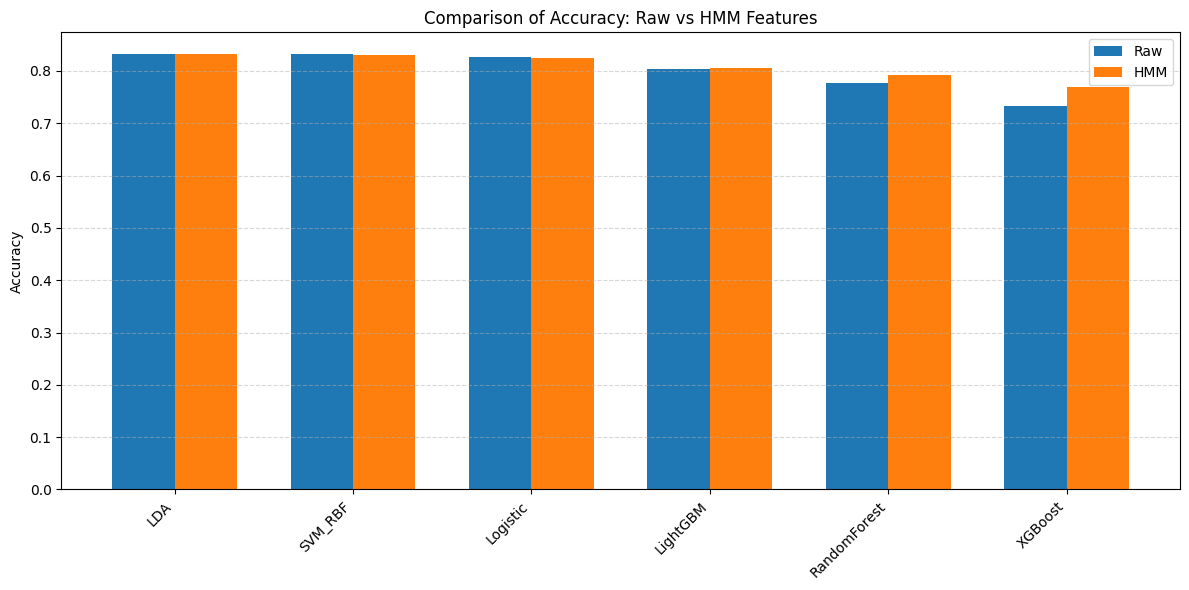

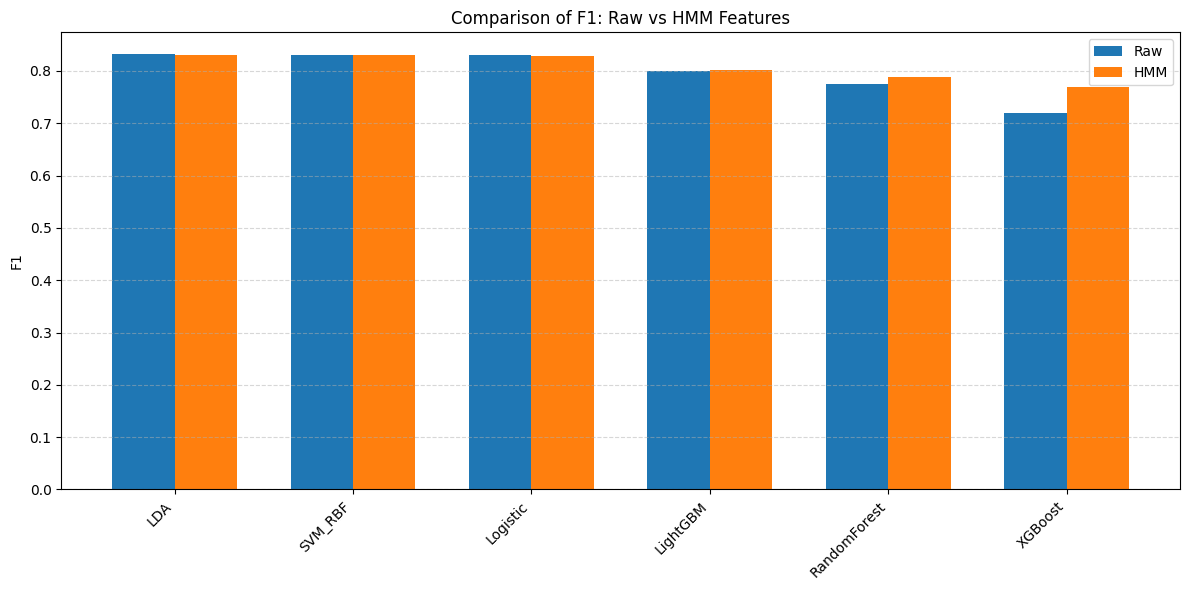

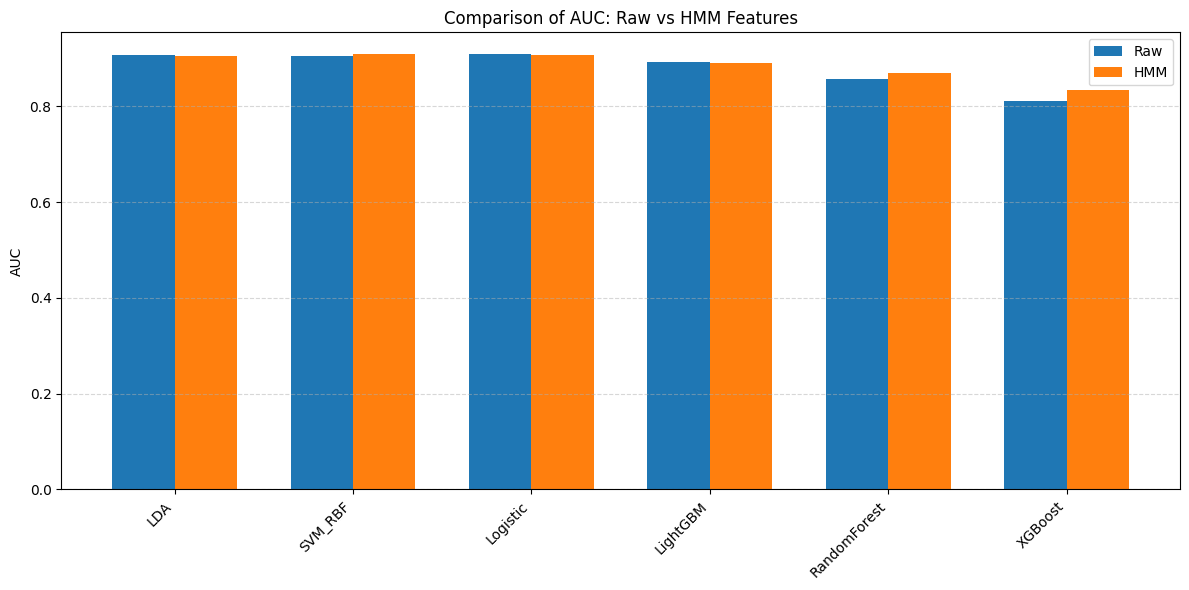

In [9]:
plot_metric_compare(df_norm, df_aug, metric="Accuracy")
plot_metric_compare(df_norm, df_aug, metric="F1")
plot_metric_compare(df_norm, df_aug, metric="AUC")